# K3 — 0.0 — MODELAGEM E TREINAMENTO - BASE EXPANDIDA

**Objetivo:** 
- Conduzir a modelagem e o treinamento na base expandida (Kaggle otimizado) para responder às frentes:
  - H9 (NLP/Multilabel): inferir gênero a partir do Overview e extrair insights de texto.
  - H10 (Fatores de faturamento): identificar drivers de alta receita/expectativa de faturamento com modelos interpretáveis e análise estatística.
  - H11 (Regressão IMDb): prever a nota IMDb com diferentes algoritmos, comparar desempenho e salvar o melhor modelo para inferência.

**Escopo:**
- Dados de entrada: data/processed/kaggle_otimizado.csv (e derivados de K01/K02).
- Engenharia de atributos (geral): normalizações e derivadas (ex.: log_budget, log_revenue, ROI, runtime_min, contagens e one-hot de genres_list, codificação de original_language, director, star1–4, popularidade e votos).
- Particionamento: train/valid/test estratificado quando aplicável; random_state fixo.
- Pipelines & Pré-processamento: ColumnTransformer (numéricos com escala/log e imputação; categóricos com one-hot e handle_unknown='ignore'; texto com TF-IDF para H9).

**Modelos:**
- H9 (texto -> gênero multilabel): TF-IDF + Logistic Regression/Naive Bayes (multilabel) e one-vs-rest.
- H10 (fatores): modelos lineares/árvore (ex.: Logistic/Linear, RandomForest/GradientBoosting) + SHAP/LIME e testes (ANOVA/OLS robusto) para suporte causal exploratório.
- H11 (nota IMDb): LinearRegression, Ridge, ElasticNetCV, RandomForestRegressor, HistGradientBoostingRegressor (e variações equivalentes).

**Métricas:**
- H9: F1 (micro/macro).
- H10: acurácia, feature importance e SHAP; testes estatísticos (p-values, ICs).
- H11: RMSE, MAE, R² em validação e teste.
- Persistência de artefatos: salvar pipelines treinadas (.joblib/.pkl), e arquivos auxiliares.

**Saída principal:**
- Modelos/artefatos:
  - models/h9_multilabel_pipeline.joblib (prevê genêro a partir da sinopse).
  - models/h11_imdb_rating_model.pkl (modelo final de nota IMDb).

# K3 — 1.0 — Imports

In [ ]:
# =====================================================
# 1. Manipulação e Análise de Dados
# =====================================================
import pandas as pd
import numpy as np
import re
import ast
import json
import joblib
from collections import Counter
from pathlib import Path
from scipy.stats import chi2_contingency, ttest_ind, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm


# =====================================================
# 2. Visualização de Dados
# =====================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
from tabulate import tabulate
import shap


# =====================================================
# 3. Pré-processamento e Modelagem
# =====================================================
# Pipeline e Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, ElasticNetCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv

# Seleção de Features e Otimização
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
    RandomizedSearchCV,
    HalvingGridSearchCV
)
from lime.lime_tabular import LimeTabularExplainer

# Métricas de Avaliação
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    hamming_loss,
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.inspection import permutation_importance
from math import sqrt

# =====================================================
# 4. Ferramentas e Utilidades
# =====================================================
import os
import pickle
import warnings
from IPython.display import display, Image, HTML

In [2]:
warnings.filterwarnings('ignore')

In [3]:
NEUTRAL = "#B3B5B6"
HILIGHT = "#F58518"

# K3 — 2.0 — Funções Auxiliares

In [4]:
# ==== Caminhos & Display ====
class PATHS:
    """
    Caminhos padrão do projeto quando o notebook roda dentro de 'notebooks/'.

    Regra:
    - Se o cwd termina com 'notebooks', a raiz é o pai (../)
    - Caso contrário, assume que já estamos na raiz (útil se abrir o Jupyter na raiz)
    """
    _CWD = Path.cwd()
    ROOT = _CWD.parent if _CWD.name == "notebooks" else _CWD
    RAW  = ROOT / "data" / "raw"
    PROC = ROOT / "data" / "processed"
    INTER = ROOT / "data" / "intermediary"
    REP  = ROOT / "reports"
    FIG  = REP / "figures"
    
    # Adiciona a pasta de modelos
    MODELS = ROOT / "models" 

def ensure_dirs():
    """Garante que as pastas principais existam."""
    for p in [PATHS.RAW, PATHS.INTER, PATHS.PROC, PATHS.REP, PATHS.FIG]:
        p.mkdir(parents=True, exist_ok=True)

def set_display(max_cols: int = 50, decimals: int = 2):
    """Ajusta visualização padrão no Pandas/Seaborn para leitura eficiente."""
    pd.options.display.max_columns = max_cols
    fmt = "{:." + str(decimals) + "f}"
    pd.options.display.float_format = fmt.format
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ==== Parsing & Normalização ====
def normalize_title(s):
    """Normaliza título: minúsculas, sem pontuação, sem espaços extras."""
    if pd.isna(s):
        return np.nan
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^\w\s]", "", s)
    return s.strip()

def parse_year(x):
    """Extrai o primeiro ano encontrado (ex.: '1994' ou '1994(I)')."""
    if pd.isna(x):
        return pd.NA
    m = re.search(r"\d{4}", str(x))
    return int(m.group()) if m else pd.NA

def to_numeric_safe(series):
    """Converte para numérico com 'coerce' (incompatíveis viram NaN)."""
    return pd.to_numeric(series, errors="coerce")

def _to_list_of_dicts(val):
    """Converte a célula (string JSON, lista de dicts, vazio) para uma lista de dicts segura."""
    # 1) valores vazios/NaN
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return []
    # 2) já é lista
    if isinstance(val, list):
        return [x for x in val if isinstance(x, dict)]
    # 3) string (tentar literal_eval, depois json.loads)
    if isinstance(val, str):
        s = val.strip()
        if not s or s.lower() in {"nan", "none", "null"}:
            return []
        for loader in (ast.literal_eval, json.loads):
            try:
                obj = loader(s)
                break
            except Exception:
                obj = None
        if isinstance(obj, list):
            return [x for x in obj if isinstance(x, dict)]
        else:
            return []
    # 4) qualquer outro tipo
    return []

def extract_list_key(val, key):
    """Extrai uma lista com o campo `key` de cada dict (ignorando vazios)."""
    lst = _to_list_of_dicts(val)
    return [d.get(key) for d in lst if isinstance(d, dict) and d.get(key)]

def normalize_str_list(L):
    """Limpa uma lista de strings: trim + remove vazios/None."""
    if not isinstance(L, list):
        return []
    return [x.strip() for x in L if isinstance(x, str) and x.strip()]

def _to_list(x):
    if isinstance(x, list): 
        return x
    if pd.isna(x):
        return []
    s = str(x).strip()
    if not s:
        return []
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else []
    except Exception:
        s = re.sub(r"[\[\]\'\"]", "", s)
        toks = [t.strip() for t in s.split(",") if t.strip()]
        return toks

def ensure_labels(pred_scores, classes_, threshold=0.40, top_k=2):
    pred_bin = (pred_scores >= threshold).astype(int)
    for i in range(pred_bin.shape[0]):
        if pred_bin[i].sum() < top_k:
            top_idx = np.argsort(pred_scores[i])[::-1][:top_k]
            pred_bin[i, top_idx] = 1
    return pred_bin
    
# ==== Parsing & Engenharia de Atributos (Data) ====
def _season(m):
    """Determina a estação do ano a partir do número do mês (hem. norte)."""
    if pd.isna(m): return np.nan
    m = int(m)
    if m in (12,1,2):   return "winter"
    if m in (3,4,5):    return "spring"
    if m in (6,7,8):    return "summer"
    return "fall"

# ==== Deduplicação ====
def dedup_by_key(df, keys, score_col="vote_count"):
    """
    Se houver múltiplas linhas para a mesma chave, mantém a de maior `score_col`.
    Ex.: ao agrupar por (title_norm, year), fica a linha com maior número de votos.
    """
    tmp = df.copy()
    tmp[score_col] = to_numeric_safe(tmp[score_col]) if score_col in tmp.columns else 0
    tmp = tmp.sort_values(by=[score_col], ascending=False)
    return tmp.drop_duplicates(subset=keys, keep="first")

# === Cálculo de coeficiente entre variáveis categóricas ===
# Função para calcular o Cramer's V
def cramer_v(x, y):
    """Calcula o Cramer's V para duas variáveis categóricas."""
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    phi2 = chi2 / n
    phi2_adj = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_adj = r - ((r-1)**2)/(n-1)
    k_adj = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_adj / min(k_adj, r_adj))

In [5]:
# Chamo as de caminhos e display
ensure_dirs()
set_display()

# K3 — 3.0 — Carregando os Dados

In [6]:
# 1. Carrego os dados através da classe
df = pd.read_csv(PATHS.PROC / "kaggle_otimizado.csv", low_memory=False)

# K3 — 4.0 — Engenharia de Atributos

- Por que essas novas colunas?
  * **log_budget, log_revenue, roi:** dão sinal econômico robusto (e “domam” outliers).
  * **n_countries, n_genres, has_stars, overview_len, is_english:** features baratas com potencial preditivo (coprodução, complexidade do produto, sinal de elenco, força do texto, idioma).
  * **decade, release_month, release_season:** efeitos temporais/sazonais (úteis para H10 e H11).
  * **budget_milhoes, revenue_milhoes:** ótimos para gráficos e interpretação humana (não atrapalham modelos).

In [7]:
# 2. Realizo a tipagem e Engenharia de Atributos
df_master = df.copy()

In [8]:
## 2.1 - Tipagem e conversão de datas
for c in ["budget", "revenue", "popularity", "runtime", "vote_average", "num_ratings", "vote_count", "mean_rating", "year"]:
    if c in df_master.columns:
        df_master[c] = pd.to_numeric(df_master[c], errors="coerce")
if "release_date" in df_master.columns:
    df_master["release_date"] = pd.to_datetime(df_master["release_date"], errors="coerce")

In [9]:
## 2.2 - Variáveis derivadas
df_master["log_budget"] = np.log1p(df_master["budget"])
df_master["log_revenue"] = np.log1p(df_master["revenue"])
df_master["roi"] = df_master["revenue"] / df_master["budget"]
df_master.loc[~np.isfinite(df_master["roi"]), "roi"] = np.nan

In [10]:
# Versões em milhões
df_master["budget_milhoes"] = df_master["budget"] / 1_000_000
df_master["revenue_milhoes"] = df_master["revenue"] / 1_000_000

In [11]:
# Contagens e flags
df_master["genres_list"] = df_master["genres_list"].map(_to_list)
df_master["countries_names"] = df_master["countries_names"].map(_to_list)
df_master["n_countries"] = df_master["countries_names"].map(len)
df_master["n_genres"] = df_master["genres_list"].map(len)
df_master["has_director"] = df_master["director"].notna().astype(int)
df_master["has_stars"] = df_master[["star1","star2","star3","star4"]].notna().sum(axis=1)
df_master["overview_len"] = df_master["overview"].map(lambda s: len(str(s).split()) if pd.notna(s) else 0)
df_master["is_english"] = (df_master.get("original_language", "") == "en").astype(int)

In [12]:
# Tempo
df_master["year"] = df_master["year"].astype("Int64")
df_master["decade"] = (df_master["year"].astype("float") // 10 * 10).astype("Int64")
if "release_date" in df_master.columns:
    df_master["release_year"] = df_master["release_date"].dt.year.astype("Int64")
    df_master["release_month"] = df_master["release_date"].dt.month
    df_master["release_season"] = df_master["release_month"].map(_season)

In [13]:
# C - Imputação de valores
# Ordem de imputação: primeiro a mediana (runtime), depois os zeros
if df_master["runtime"].notna().sum():
    df_master["runtime"] = df_master["runtime"].fillna(df_master["runtime"].median())
if "popularity" in df_master.columns:
    df_master["popularity"] = df_master["popularity"].fillna(0)

In [14]:
# Imputação de budget e revenue
df_master["budget"] = df_master["budget"].fillna(0)
df_master["revenue"] = df_master["revenue"].fillna(0)

# K3 — 5.0 — Treinamento dos Modelos

## K3 — 5.1 — H9. Overview ajuda a inferir gênero? Quais insights podem ser tirados dela?
R: Sim, o texto da sinopse (overview) carrega sinal suficiente para acertar bem os gêneros amplos (Drama, Comedy, Documentary, Horror, Action), mas tem dificuldade em classes menores/ambíguas (Fantasy, History, Foreign, TV Movie). No setup multilabel (que permite mais de um gênero por filme), o modelo alcançou F1-micro ≈ 0,57 e F1-macro ≈ 0,43. Em termos práticos: para a maioria dos filmes ele recupera pelo menos um gênero correto, porém ainda confunde subgêneros/adjacentes e gêneros pouco representados.

**Insights do Modelo:**
* **Onde vai bem:**
Drama, Comedy, Documentary, Horror e Action têm vocabulário mais característico e frequente nas sinopses → maior recall e precision.

* **Onde sofre:**
Fantasy, History, Foreign, TV Movie e alguns subgêneros (Mystery, Family) aparecem menos e compartilham termos genéricos com Drama/Thriller → baixa separabilidade.

* **Métrica multilabel:** (melhor modelo)
  * F1-micro 0,56 (puxa pelo desempenho nas maiores classes)
  * F1-macro 0,30 (mostra que classes pequenas ainda estão fracas)
  * Subset accuracy 0,102 (critério rígido: acertar exatamente todos os rótulos)
  * Hamming loss 0,066 (poucos erros por rótulo, em média)

* **Implicações no negócio:**
  * Viável para “pré-tagueamento”: dá para usar o modelo para sugerir 2–3 gêneros por filme (threshold + Top-K), acelerando curadoria e QA.
  * Não substitui curadoria humana em casos sutis: subgêneros e classes raras exigem revisão editorial.

* **Próximos passos:** balancear melhor as classes, usar embeddings (p.ex., BERT) e calibrar thresholds por classe tendem a elevar F1-macro.

### K3 — 5.1.1 — Carregando dados Isolados e Seleção das Variáveis Alvos

* **Input (X):** ``overview``.
* **Target(y):** ``genres_list``.

**Decisão:** Como baseline, irei tratar como uma tarefa multiclasse, ou seja, usando só o primeiro Gênero da lista. Caso o modelo não performe bem, irei tratá-lo como tarefa multilabel.

In [15]:
# Gero cópia de segurança
df_h9 = df_master.copy()

In [16]:
# Seleciono e dropo as variáveis alvos
df_h9 = df_h9.dropna(subset=["overview", "genres_list"])

### K3 — 5.1.2 — Treinamentos dos Modelos Multiclasse

* Testamos GridSearch exaustivo, mas os resultados não superaram o baseline, com custo computacional elevado (~3h), levando a optar por remover o código (resultado: Fitting 5 folds for each of 24 candidates, totalling 120 fits. Melhor combinação: {'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)} F1-macro (CV treino): 0.191. Acurácia no teste: 0.474 F1-macro no teste: 0.203).
  
* Os testes com Halving GridSearch confirmam o qual desbalanceado são as classes, por isso o modelo tende a performar melhor para as classes que mais tem.

* Testamos rebalancear as classes. O modelo conseguiu performar pior do que com Halving GridSearch. Partmos para treinar modelos multilabel.

In [17]:
# Cópia para garantir isolamento do treinamento dos modelos subsequentes
df_mm = df_h9.copy()

# --- Limpo Genres
df_mm["genres_list_parsed"] = df_mm["genres_list"].apply(_to_list)
df_mm = df_mm[df_mm["genres_list_parsed"].map(len) > 0]
df_mm["main_genre"] = df_mm["genres_list_parsed"].str[0]

# --- Filtro a Classes Raras
min_per_class = 20
vc = df_mm["main_genre"].value_counts()
keep = vc[vc >= min_per_class].index
df_mm = df_mm[df_mm["main_genre"].isin(keep)]

# --- Definição e Divisão dos Conjuntos de Dados
X = df_mm["overview"].astype(str)
y = df_mm["main_genre"].astype(str)

# Separa a base em treino e teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Tamanho treino/teste:", X_train.shape[0], "/", X_test.shape[0])
print("Nº classes (após filtro):", y.nunique())

Tamanho treino/teste: 33817 / 8455
Nº classes (após filtro): 20


In [18]:
# Modelo Baseline CV (TF-IDF + LogReg) — sem gridsearch
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(min_df=2, ngram_range=(1,1))),
    ("clf", LogisticRegression(max_iter=300))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"Acurácia (5-fold CV, treino): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Acurácia (5-fold CV, treino): 0.460 ± 0.006


In [19]:
# Modelagem e Otimização com HalvingGridSearchCV
X_train = ['movie review 1', 'movie review 2', 'movie review 3', 'movie review 4', 'movie review 5'] * 10
y_train = [0, 1, 0, 1, 0] * 10
X_test = ['test review 1', 'test review 2']
y_test = [0, 1]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(dtype=np.float32)),
    ("clf", LogisticRegression(max_iter=200, n_jobs=1, solver="lbfgs"))
])

param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [3, 5],
    "tfidf__max_features": [30000, 50000],
    "clf__C": [0.25, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
sh = HalvingGridSearchCV(
    pipe, param_grid=param_grid, cv=cv, scoring="f1_macro",
    factor=2,
    verbose=1, n_jobs=1
)
sh.fit(X_train, y_train)

print("Melhor:", sh.best_params_, "F1-macro CV:", sh.best_score_)
y_pred = sh.best_estimator_.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("F1-macro:", f1_score(y_test, y_pred, average="macro"))

n_iterations: 3
n_required_iterations: 5
n_possible_iterations: 3
min_resources_: 12
max_resources_: 50
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 12
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 12
n_resources: 24
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 6
n_resources: 48
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Melhor: {'clf__C': 1.0, 'tfidf__max_features': 30000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)} F1-macro CV: 0.3814102564102564
Acurácia: 0.5
F1-macro: 0.3333333333333333


In [20]:
# Modelo comparativo 2 - RandomOverSampler (balanceando as classes)
pipe_ros = ImbPipeline([
    ("tfidf",  TfidfVectorizer(min_df=3, ngram_range=(1,2))),
    ("ros",    RandomOverSampler(random_state=42)),
    ("clf",    LogisticRegression(max_iter=200, solver="lbfgs", C=1.0, n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_f1 = cross_val_score(pipe_ros, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
print(f"F1-macro (CV treino, ROS): {cv_f1.mean():.3f} ± {cv_f1.std():.3f}")

pipe_ros.fit(X_train, y_train)
y_pred = pipe_ros.predict(X_test)
print("Acurácia (teste):", accuracy_score(y_test, y_pred))
print("F1-macro (teste):", f1_score(y_test, y_pred, average="macro"))
print("\nRelatório de classificação (teste):\n", classification_report(y_test, y_pred))

F1-macro (CV treino, ROS): 0.375 ± 0.000
Acurácia (teste): 0.5
F1-macro (teste): 0.3333333333333333

Relatório de classificação (teste):
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



### K3 — 5.1.3 — Treinamento do Modelo Multilabel

In [21]:
# Prepara multilabel
df_tmm = df_h9.copy()
df_tmm["genres_list_parsed"] = df_tmm["genres_list"].apply(_to_list)
df_tmm = df_tmm[df_tmm["genres_list_parsed"].map(len) > 0]

X = df_tmm["overview"].astype(str).values
Y_list = df_tmm["genres_list_parsed"].values

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(Y_list)
classes_ = mlb.classes_

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

In [22]:
# ================== Pipeline e Treino ==================
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        stop_words="english",
        ngram_range=(1, 2),
        min_df=2,
        max_features=150_000
    )),
    ("clf", OneVsRestClassifier(
        LogisticRegression(
            C=2.0,
            penalty="l2",
            solver="lbfgs",
            max_iter=200
        ),
        n_jobs=-1
    ))
])

pipe.fit(X_train, Y_train)
print(f"Classes: {list(classes_)}")
print("Amostras:", X.shape[0], "| Nº classes:", len(classes_))

Classes: ['Action', 'Adventure', 'Animation', 'Aniplex', 'BROSTA TV', 'Carousel Productions', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'GoHands', 'History', 'Horror', 'Mardock Scramble Production Committee', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Sentai Filmworks', 'TV Movie', 'Telescene Film Group Productions', 'Thriller', 'Vision View Entertainment', 'War', 'Western']
Amostras: 42274 | Nº classes: 28


In [23]:
# ================== Predição com threshold + Top-K ==================
THRESHOLD = 0.40
TOP_K = 2

proba = pipe.predict_proba(X_test)
Y_pred_bin = ensure_labels(proba, classes_, threshold=THRESHOLD, top_k=TOP_K)

In [24]:
# ================== Métricas Multilabel ==================
f1_micro = f1_score(Y_test, Y_pred_bin, average="micro", zero_division=0)
f1_macro = f1_score(Y_test, Y_pred_bin, average="macro", zero_division=0)
subset_acc = accuracy_score(Y_test, Y_pred_bin)
hamm = hamming_loss(Y_test, Y_pred_bin)

print(f"F1-micro: {f1_micro:.3f}")
print(f"F1-macro: {f1_macro:.3f}")
print(f"Subset accuracy: {subset_acc:.3f}")
print(f"Hamming loss: {hamm:.3f}")

print("\nRelatório por classe:")
print(classification_report(Y_test, Y_pred_bin, target_names=classes_, zero_division=0))

F1-micro: 0.568
F1-macro: 0.303
Subset accuracy: 0.102
Hamming loss: 0.066

Relatório por classe:
                                       precision    recall  f1-score   support

                               Action       0.55      0.55      0.55      1275
                            Adventure       0.49      0.22      0.31       687
                            Animation       0.81      0.24      0.37       372
                              Aniplex       0.00      0.00      0.00         0
                            BROSTA TV       0.00      0.00      0.00         0
                 Carousel Productions       0.00      0.00      0.00         0
                               Comedy       0.51      0.76      0.61      2557
                                Crime       0.56      0.35      0.43       872
                          Documentary       0.71      0.74      0.73       759
                                Drama       0.58      0.90      0.70      4036
                               F

In [25]:
# Top-10 gêneros mais previstos
pred_counts = Y_pred_bin.sum(axis=0)
top_idx = np.argsort(pred_counts)[::-1][:10]
print("\nTop 10 gêneros mais previstos no teste:")
for i in top_idx:
    print(f"{classes_[i]} — {int(pred_counts[i])} filmes")


Top 10 gêneros mais previstos no teste:
Drama — 6268 filmes
Comedy — 3778 filmes
Thriller — 1581 filmes
Romance — 1302 filmes
Action — 1268 filmes
Documentary — 789 filmes
Horror — 770 filmes
Crime — 543 filmes
Science Fiction — 433 filmes
Adventure — 315 filmes


In [26]:
# Guarda referências
Yt = Y_test
Yp = Y_pred_bin
X_test_arr = np.asarray(X_test)  # garante indexação

In [27]:
# ================== Salva o Pipeline para Produção ==================
artifact = {
    "pipeline": pipe,
    "mlb": mlb,
    "threshold": THRESHOLD,
    "top_k": TOP_K
}
model_path = PATHS.MODELS / "h9_multilabel_pipeline.joblib"
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(artifact, model_path)
print(f"Salvo em: {model_path}")

Salvo em: /home/emersds/repos_projetos/project_lighthouse/models/h9_multilabel_pipeline.joblib


### K3 — 5.1.4 — Tradução para Linguagem de Negócio

In [28]:
# ================== Função de inferência (Ambiente de Produção) ==================
model_path = PATHS.MODELS / "h9_multilabel_pipeline.joblib"

def predict_genres_overview(texts, model_path=PATHS.MODELS / "h9_multilabel_pipeline.joblib",
                            threshold=None, top_k=None, return_scores=True):
    if isinstance(texts, str):
        texts = [texts]
    art = joblib.load(model_path)
    pipe_ = art["pipeline"]
    mlb_ = art["mlb"]
    thr = art["threshold"] if threshold is None else threshold
    tk  = art["top_k"]     if top_k is None else top_k

    proba_ = pipe_.predict_proba(texts)
    pred_bin_ = ensure_labels(proba_, mlb_.classes_, threshold=thr, top_k=tk)

    outputs = []
    for i in range(len(texts)):
        labels_idx = np.where(pred_bin_[i] == 1)[0]
        labels = mlb_.classes_[labels_idx]
        if return_scores:
            scores = proba_[i, labels_idx]
            ord_idx = np.argsort(scores)[::-1]
            labels = labels[ord_idx]
            scores = scores[ord_idx]
            outputs.append(list(zip(labels.tolist(), scores.round(3).tolist())))
        else:
            outputs.append(labels.tolist())
    return outputs

In [29]:
# ================== Prevê as probabilidades de gênero através da sinopse (Overview) ==================
exemplos = [
    "A group of teenagers spend the night in a haunted house where strange events begin to unfold.",
    "A heartfelt story about a family overcoming challenges during a road trip across the country.",
    "A young wizard begins his journey at a school of magic"
]

preds = predict_genres_overview(exemplos, threshold=0.40, top_k=2, return_scores=True)
for txt, out in zip(exemplos, preds):
    print("\nSinopse:", txt)
    print("Gêneros previstos (prob.):")
    for g, p in out:
        print(f"  - {g}: {p:.3f}")


Sinopse: A group of teenagers spend the night in a haunted house where strange events begin to unfold.
Gêneros previstos (prob.):
  - Horror: 0.914
  - Thriller: 0.536

Sinopse: A heartfelt story about a family overcoming challenges during a road trip across the country.
Gêneros previstos (prob.):
  - Drama: 0.758
  - Comedy: 0.494

Sinopse: A young wizard begins his journey at a school of magic
Gêneros previstos (prob.):
  - Family: 0.503
  - Fantasy: 0.474
  - Drama: 0.451


In [30]:
# ================== Prevê as palavras mais fortes por gênero ==================
art = joblib.load(PATHS.MODELS / "h9_multilabel_pipeline.joblib")
pipe_loaded = art["pipeline"]
tfidf = pipe_loaded.named_steps["tfidf"]
ovr   = pipe_loaded.named_steps["clf"]
terms = np.array(tfidf.get_feature_names_out())
classes = art["mlb"].classes_

def top_terms_for_class(class_idx, k=15):
    clf_c = ovr.estimators_[class_idx]
    coefs = clf_c.coef_.ravel()
    top   = np.argsort(coefs)[::-1][:k]
    return [terms[i] for i in top]

for cname in ["Drama","Comedy","Horror","Action","Documentary"]:
    i = list(classes).index(cname)
    print(f"\nTop termos — {cname}")
    print(top_terms_for_class(i, k=15))


Top termos — Drama
['drama', 'true story', 'affair', 'prostitute', 'relationship', 'lives', 'love', 'mother', 'friendship', 'story', 'tragedy', 'year old', 'wife', 'young', '1950s']

Top termos — Comedy
['comedy', 'hilarious', 'comic', 'comedic', 'bumbling', 'funny', 'comedian', 'spoof', 'wedding', 'satire', 'eccentric', 'mistaken', 'crazy', 'misadventures', 'chef']

Top termos — Horror
['horror', 'vampire', 'zombie', 'blood', 'zombies', 'evil', 'terrifying', 'vampires', 'supernatural', 'killer', 'dead', 'house', 'creature', 'mysterious', 'nightmare']

Top termos — Action
['assassin', 'cop', 'action', 'martial', 'fight', 'cia', 'warrior', 'mercenary', 'agent', 'yakuza', 'ruthless', 'battle', 'hitman', 'criminals', 'target']

Top termos — Documentary
['documentary', 'interviews', 'filmmaker', 'footage', 'look', 'history', 'portrait', 'film', 'journey', 'documents', 'camera', 'world', 'examines', 'explores', 'america']


In [31]:
# ================== Bloco de exemplos (Acertos/Erros) ==================
# Calcula índices de acerto/erro
# - acerto exato: vetor de rótulos idêntico
idx_correct = np.where((Yp == Yt).all(axis=1))[0]

# - parcial: ao menos 1 interseção, mas não idêntico
inter = (Yp & Yt).sum(axis=1)
diff  = (Yp != Yt).any(axis=1)
idx_partial = np.where((inter > 0) & diff)[0]

# - erro total: sem interseção
idx_wrong = np.where(inter == 0)[0]

def labels_from_bin(binrow):
    return [classes_[i] for i in np.where(binrow == 1)[0]]

def show_case(ix):
    text = X_test_arr[ix]
    print("\nTEXTO   :", str(text)[:220].strip(), "...")
    print("Verdadeiro:", labels_from_bin(Yt[ix]))
    print("Previsto  :", labels_from_bin(Yp[ix]))
    top = np.argsort(proba[ix])[::-1][:5]
    print("Scores    :", [(classes_[j], float(proba[ix, j])) for j in top])

print("\n=== EXEMPLOS (acerto exato) ===")
for ix in idx_correct[:3]:
    show_case(ix)

print("\n=== EXEMPLOS (acerto parcial) ===")
for ix in idx_partial[:3]:
    show_case(ix)

print("\n=== EXEMPLOS (erro total) ===")
for ix in idx_wrong[:3]:
    show_case(ix)


=== EXEMPLOS (acerto exato) ===

TEXTO   : A bittersweet tale of lost love, based on a short story ("The Apple Tree") by John Galsworthy. ...
Verdadeiro: ['Drama', 'Romance']
Previsto  : ['Drama', 'Romance']
Scores    : [('Drama', 0.8472745698402602), ('Romance', 0.5409754115687311), ('Comedy', 0.11344631500298306), ('Fantasy', 0.10525728042477894), ('Thriller', 0.06634044245152068)]

TEXTO   : A woman attempts to overcome her paralyzing fear of speed in order to win an underground racing competition and prevent her friends from falling prey to a vicious drug lord in director Jeff Centauri's sexy thrill-ride. I ...
Verdadeiro: ['Action', 'Comedy']
Previsto  : ['Action', 'Comedy']
Scores    : [('Action', 0.4057398183642764), ('Comedy', 0.29997439448351865), ('Thriller', 0.2637370970861806), ('Drama', 0.26198242592560145), ('Family', 0.13887845918197264)]

TEXTO   : A simple, delicate, melodramatic German film about a loneliness. With a double moral story about the tainted love between 

## K3 — 5.2 — H10. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?
R: O faturamento de um filme é explicado principalmente por orçamento e engajamento do público. Idioma inglês, lançamento no verão e gêneros como Aventura contribuem positivamente em termos absolutos. Horror, apesar de faturar menos em média, mostra eficiência relativa ao orçamento. Diretores e estrelas consagradas também se associam a maior receita, mas de forma menos consistente.

In [32]:
# Cópia de segurança
df_h10 = df_master.copy()

### K3 — 5.2.1 — Análise Exploratória Específica

A análise exploratória mostrou que o orçamento é o fator isolado mais fortemente relacionado ao faturamento dos filmes (correlação ≈ 0.70 em log-escala), indicando que produções maiores tendem a gerar maiores receitas. Métricas de engajamento do público como número de votos e popularidade também apresentaram correlações relevantes, reforçando a importância da aceitação do público para o sucesso comercial. Fatores secundários, como estação de lançamento (com destaque para o verão), idioma inglês e a presença de diretores/atores renomados, também aparecem associados a maiores receitas, ainda que com efeito menos consistente. Esses achados fornecem os primeiros indícios de quais variáveis devem ser priorizadas na modelagem explicativa.

In [33]:
# ================== Preparação dos dados ==================
df = df_h10.copy()

# Garante tipos numéricos onde importa
num_cols = [
    'revenue','budget','popularity','runtime','vote_average','vote_count',
    'mean_rating','num_ratings','log_revenue','log_budget','roi',
    'budget_milhoes','revenue_milhoes','n_countries','n_genres',
    'overview_len','year','release_year','release_month','decade'
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Filtros mínimos
df = df[(df['revenue'] > 0) & (df['budget'] > 0)].dropna(subset=['revenue','budget'])

df['genres_list'] = df['genres_list'].apply(_to_list)

# --- Gênero primário
def first_genre_safe(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return x[0] if len(x) else np.nan
    if x is None:
        return np.nan
    s = str(x).strip()
    if not s:
        return np.nan
    if s.startswith('[') and s.endswith(']'):
        try:
            li = ast.literal_eval(s)
            if isinstance(li, list) and len(li):
                return li[0]
            return np.nan
        except Exception:
            pass
    if '|' in s:
        return s.split('|')[0].strip()
    if ',' in s:
        return s.split(',')[0].strip()
    return s

df['genre_primary'] = df['genres_list'].apply(first_genre_safe)

# Log-transform segura
if 'log_revenue' not in df.columns:
    df['log_revenue'] = np.log1p(df['revenue'])
if 'log_budget' not in df.columns:
    df['log_budget'] = np.log1p(df['budget'])

# Categóricas úteis
if 'original_language' in df.columns:
    df['original_language'] = df['original_language'].astype(str)
if 'release_season' in df.columns:
    df['release_season'] = df['release_season'].astype(str)
if 'director' in df.columns:
    df['director'] = df['director'].fillna('UNK').astype(str)
for c in ['star1','star2','star3','star4']:
    if c in df.columns:
        df[c] = df[c].fillna('UNK').astype(str)

print(df.shape)
display(df[['revenue','budget','log_revenue','log_budget']].describe().T)


(5375, 37)


,count,mean,std,min,25%,50%,75%,max
revenue,5375.00,90391821.65,166218224.88,1.00,7020199.00,29918745.00,100000000.00,2787965087.00
budget,5375.00,31108015.75,40180263.15,1.00,5053316.00,17000000.00,40000000.00,380000000.00
log_revenue,5375.00,16.74,2.61,0.69,15.76,17.21,18.42,21.75
log_budget,5375.00,16.27,2.08,0.69,15.44,16.65,17.50,19.76


In [34]:
# Escolho variáveis numéricas candidatas
cand_num = [
    'log_budget','budget','popularity','runtime','vote_count','vote_average',
    'mean_rating','num_ratings','n_countries','n_genres','overview_len','is_english',
    'year','release_year','release_month'
]
cand_num = [c for c in cand_num if c in df.columns]

# Tabela de correlação com log_revenue e revenue
corr_rows = []
for c in cand_num:
    s = df[[c,'log_revenue','revenue']].dropna()
    if len(s) < 50:
        continue
    p_log = s[c].corr(s['log_revenue'], method='pearson')
    s_log = s[c].corr(s['log_revenue'], method='spearman')
    p_lin = s[c].corr(s['revenue'], method='pearson')
    s_lin = s[c].corr(s['revenue'], method='spearman')
    corr_rows.append([c, p_log, s_log, p_lin, s_lin])

corr_tbl = pd.DataFrame(corr_rows, columns=['feature','pearson_logR','spearman_logR','pearson_rev','spearman_rev'])
corr_tbl = corr_tbl.sort_values('pearson_logR', ascending=False)
display(corr_tbl.style.background_gradient(axis=None, cmap='coolwarm'))

,feature,pearson_logR,spearman_logR,pearson_rev,spearman_rev
0,log_budget,0.702083,0.710472,0.398413,0.710472
1,budget,0.507680,0.710472,0.730286,0.710472
4,vote_count,0.452639,0.750512,0.770559,0.750512
7,num_ratings,0.312354,0.583290,0.379984,0.583290
2,popularity,0.271600,0.584587,0.440527,0.584587
3,runtime,0.184250,0.222686,0.189634,0.222686
11,is_english,0.177134,0.208601,0.134349,0.208601
5,vote_average,0.162291,0.127567,0.167775,0.127567
9,n_genres,0.143017,0.176312,0.165220,0.176312
13,release_year,0.105268,0.116752,0.159713,0.116752


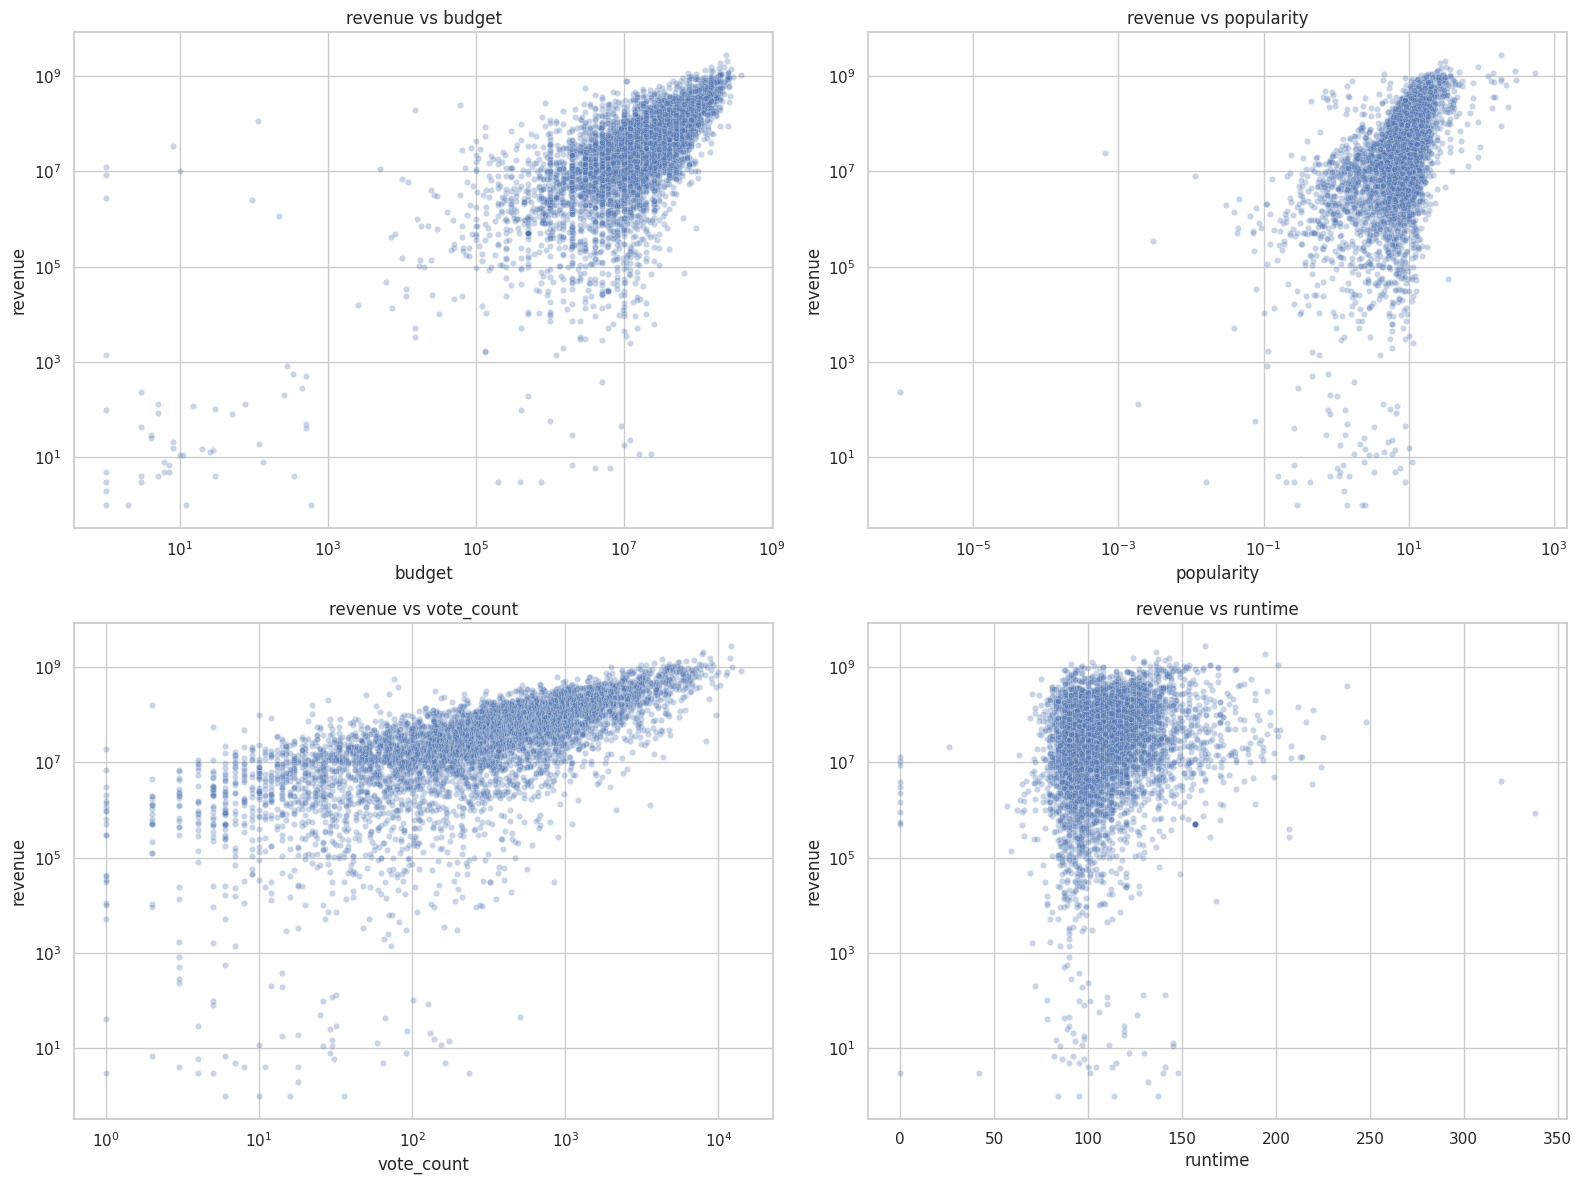

In [35]:
sns.set(style="whitegrid")

pairs = [
    ('budget','revenue'),
    ('popularity','revenue'),
    ('vote_count','revenue'),
    ('runtime','revenue')
]
n = len(pairs)
plt.figure(figsize=(16, 12))
for i, (x,y) in enumerate(pairs, 1):
    if x not in df.columns: 
        continue
    ax = plt.subplot(2, 2, i)
    sns.scatterplot(data=df, x=x, y=y, alpha=0.3, s=20)
    if x in ['budget','popularity','vote_count']: 
        ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{y} vs {x}')
plt.tight_layout()
plt.show()

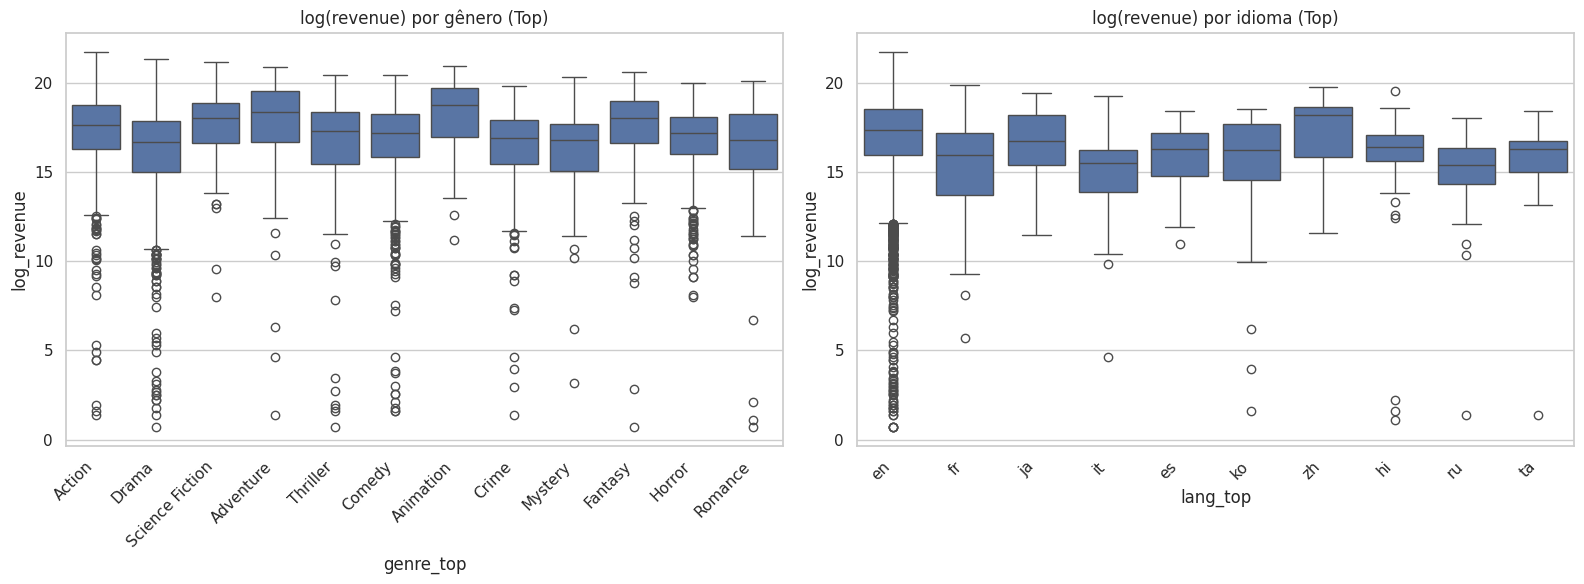

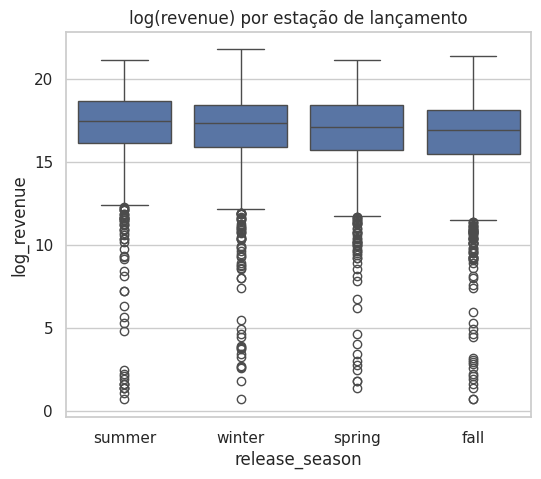

In [36]:
# Top-K categorias
K_GEN = 12
K_LANG = 10

top_gen = df['genre_primary'].value_counts().head(K_GEN).index
top_lang = df['original_language'].value_counts().head(K_LANG).index

df_box = df.copy()
df_box['genre_top'] = np.where(df_box['genre_primary'].isin(top_gen), df_box['genre_primary'], 'Other')
df_box['lang_top']  = np.where(df_box['original_language'].isin(top_lang), df_box['original_language'], 'Other')

plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
sns.boxplot(data=df_box[df_box['genre_top']!='Other'], x='genre_top', y='log_revenue')
plt.xticks(rotation=45, ha='right')
plt.title('log(revenue) por gênero (Top)')

ax = plt.subplot(1,2,2)
sns.boxplot(data=df_box[df_box['lang_top']!='Other'], x='lang_top', y='log_revenue')
plt.xticks(rotation=45, ha='right')
plt.title('log(revenue) por idioma (Top)')

plt.tight_layout()
plt.show()

if 'release_season' in df_box.columns:
    plt.figure(figsize=(6,5))
    sns.boxplot(data=df_box, x='release_season', y='log_revenue')
    plt.title('log(revenue) por estação de lançamento')
    plt.show()

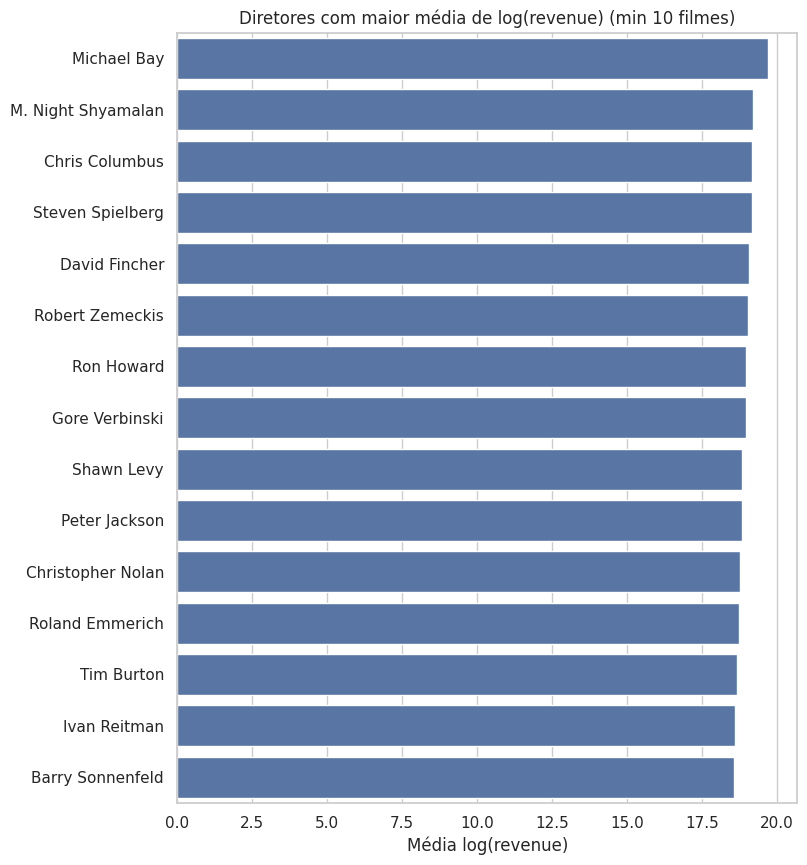

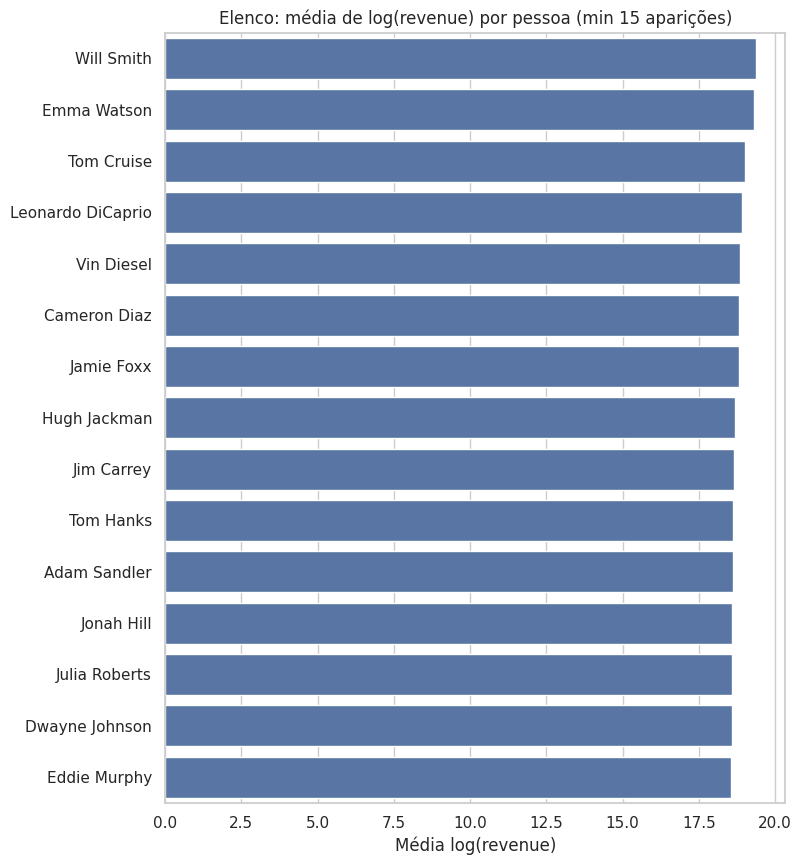

In [37]:
# Diretores com base >= 10 filmes na base
dir_stats = (
    df.groupby('director')['log_revenue']
      .agg(['count','mean'])
      .rename(columns={'mean':'mean_logR'})
      .reset_index()
)
dir_stats = dir_stats[dir_stats['count'] >= 10].sort_values('mean_logR', ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=dir_stats.head(15), y='director', x='mean_logR', orient='h')
plt.title('Diretores com maior média de log(revenue) (min 10 filmes)')
plt.xlabel('Média log(revenue)')
plt.ylabel(None)
plt.show()

# Elenco: empilha star1..star4 e medir média (min 15 aparições)
stars = []
for c in ['star1','star2','star3','star4']:
    if c in df.columns:
        s = df[[c,'log_revenue']].rename(columns={c:'star'}).dropna()
        stars.append(s)
if len(stars) > 0:
    cast = pd.concat(stars, axis=0)
    cast_stats = (
        cast.groupby('star')['log_revenue']
            .agg(['count','mean'])
            .rename(columns={'mean':'mean_logR'})
            .reset_index()
    )
    cast_stats = cast_stats[cast_stats['count'] >= 15].sort_values('mean_logR', ascending=False)

    plt.figure(figsize=(8,10))
    sns.barplot(data=cast_stats.head(15), y='star', x='mean_logR', orient='h')
    plt.title('Elenco: média de log(revenue) por pessoa (min 15 aparições)')
    plt.xlabel('Média log(revenue)')
    plt.ylabel(None)
    plt.show()

In [38]:
top_pos = corr_tbl.sort_values('pearson_logR', ascending=False).head(8)[['feature','pearson_logR','spearman_logR']]
top_neg = corr_tbl.sort_values('pearson_logR', ascending=True).head(8)[['feature','pearson_logR','spearman_logR']]
print("Top correlações positivas com log(revenue):")
display(top_pos.reset_index(drop=True))
print("Top correlações negativas com log(revenue):")
display(top_neg.reset_index(drop=True))

Top correlações positivas com log(revenue):


,feature,pearson_logR,spearman_logR
0,log_budget,0.70,0.71
1,budget,0.51,0.71
2,vote_count,0.45,0.75
3,num_ratings,0.31,0.58
4,popularity,0.27,0.58
5,runtime,0.18,0.22
6,is_english,0.18,0.21
7,vote_average,0.16,0.13


Top correlações negativas com log(revenue):


,feature,pearson_logR,spearman_logR
0,overview_len,-0.02,0.04
1,release_month,0.04,0.05
2,n_countries,0.04,0.06
3,mean_rating,0.07,0.05
4,year,0.11,0.12
5,release_year,0.11,0.12
6,n_genres,0.14,0.18
7,vote_average,0.16,0.13


### K3 — 5.2.2 — Modelos Preditivos/Explicativos (Logística + Árvores + SHAP)

Os modelos de regressão e árvores confirmaram que o orçamento é o principal preditor da receita, explicando grande parte da variação observada. Além dele, variáveis de engajamento como número de votos e avaliações médias mostraram efeito relevante e consistente. As árvores de decisão reforçaram essa hierarquia, com log_budget, vote_count e num_ratings dominando a importância preditiva. Interpretações via SHAP e LIME mostraram ainda que, em casos individuais, fatores como idioma, gênero e presença de atores/diretores específicos podem deslocar substancialmente a receita esperada. No geral, os modelos atingiram desempenho robusto (R² ≈ 0.65 em teste), indicando que a receita de um filme é razoavelmente previsível a partir dessas variáveis estruturais.

#### K3 — 5.2.2.1 — Regressão Linear múltipla e logística

In [39]:
df_reg = df.copy()

# alvo
y = df_reg['log_revenue']

# numéricas de interesse
num_features = ['log_budget','popularity','runtime','vote_count','vote_average',
                'num_ratings','n_countries','n_genres','overview_len']
num_features = [c for c in num_features if c in df_reg.columns]

# se não tiver genre_primary pronto a partir de genres_list
if 'genre_primary' not in df_reg.columns:
    def _first_genre(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, list):
            return x[0] if x else np.nan
        s = str(x)
        return s.split('|')[0] if '|' in s else s
    df_reg['genre_primary'] = df_reg['genres_list'].apply(_first_genre)

# reduz cardinalidade
top_langs = df_reg['original_language'].value_counts().head(10).index
df_reg['lang_red'] = np.where(df_reg['original_language'].isin(top_langs),
                              df_reg['original_language'], 'Other')

top_gen = df_reg['genre_primary'].value_counts().head(12).index
df_reg['genre_red'] = np.where(df_reg['genre_primary'].isin(top_gen),
                               df_reg['genre_primary'], 'Other')

# monta X bruto
use_cats = [c for c in ['lang_red','genre_red','release_season'] if c in df_reg.columns]
X_raw = df_reg[num_features + use_cats].copy()

# Tipa numéricas e trocar ±Inf -> NaN
for c in num_features:
    X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce').replace([np.inf, -np.inf], np.nan)

# Preenche categóricas
for c in use_cats:
    X_raw[c] = X_raw[c].fillna('UNK').astype(str)

# Monta dataframe apenas com colunas usadas + alvo e dropar NaN/Inf
df_fit = pd.concat([y.rename('log_revenue'), X_raw], axis=1)
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna()

print("Tamanho após limpeza:", df_fit.shape)

# Separa final
y = df_fit['log_revenue']
X = df_fit.drop(columns=['log_revenue'])

Tamanho após limpeza: (5369, 13)


In [40]:
# dummies
X_dum = pd.get_dummies(X, drop_first=True, dtype=float)

# garante float e finitos
X_dum = X_dum.replace([np.inf,-np.inf], np.nan).dropna(axis=1, how='all')  # evitar coluna toda NaN (raro)
mask = np.isfinite(X_dum.to_numpy()).all(axis=1) & np.isfinite(y.to_numpy())
X_dum = X_dum.loc[mask]
y     = y.loc[mask]

# OLS
import statsmodels.api as sm
X_sm = sm.add_constant(X_dum, has_constant='add')
model = sm.OLS(y, X_sm).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     113.6
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:58:08   Log-Likelihood:                -10400.
No. Observations:                5369   AIC:                         2.087e+04
Df Residuals:                    5334   BIC:                         2.110e+04
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [41]:
coef_tbl = pd.DataFrame({
    'feature': model.params.index,
    'coef': model.params.values,
    'pval': model.pvalues.values
})
coef_tbl = coef_tbl[coef_tbl['feature']!='const']
coef_tbl['abs_coef'] = coef_tbl['coef'].abs()
coef_tbl = coef_tbl.sort_values('abs_coef', ascending=False)

display(coef_tbl.head(20))

,feature,coef,pval,abs_coef
16,lang_red_ko,0.94,0.15,0.94
18,lang_red_ta,0.94,0.00,0.94
13,lang_red_hi,0.91,0.00,0.91
1,log_budget,0.81,0.00,0.81
19,lang_red_zh,0.68,0.13,0.68
26,genre_red_Horror,0.64,0.00,0.64
12,lang_red_fr,-0.61,0.03,0.61
23,genre_red_Crime,-0.45,0.00,0.45
27,genre_red_Mystery,-0.44,0.10,0.44
14,lang_red_it,-0.43,0.30,0.43


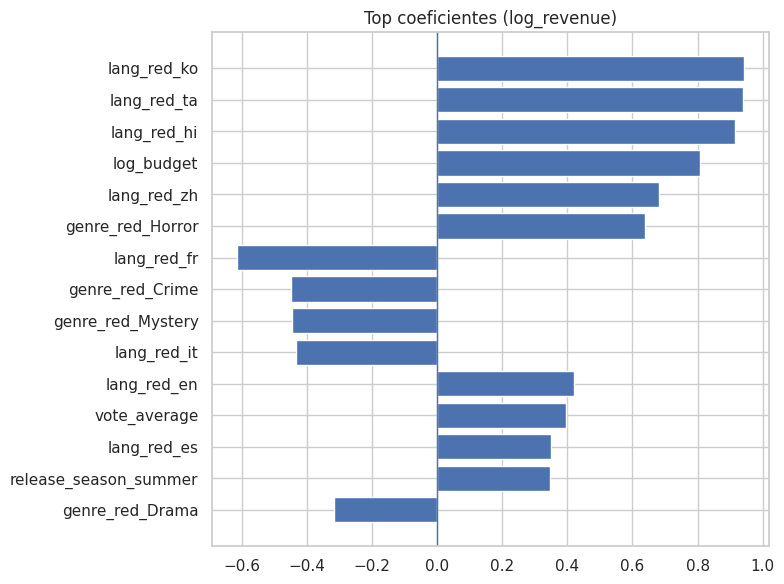

In [42]:
top_coef = coef_tbl.head(15)
plt.figure(figsize=(8,6))
plt.barh(top_coef['feature'][::-1], top_coef['coef'][::-1])
plt.axvline(0, linewidth=1)
plt.title('Top coeficientes (log_revenue)')
plt.tight_layout()
plt.show()

In [43]:
# top 8
print("Top positivos:")
display(coef_tbl[coef_tbl['coef']>0].head(8))

print("Top negativos:")
display(coef_tbl[coef_tbl['coef']<0].head(8))

Top positivos:


,feature,coef,pval,abs_coef
16,lang_red_ko,0.94,0.15,0.94
18,lang_red_ta,0.94,0.00,0.94
13,lang_red_hi,0.91,0.00,0.91
1,log_budget,0.81,0.00,0.81
19,lang_red_zh,0.68,0.13,0.68
26,genre_red_Horror,0.64,0.00,0.64
10,lang_red_en,0.42,0.03,0.42
5,vote_average,0.40,0.00,0.40


Top negativos:


,feature,coef,pval,abs_coef
12,lang_red_fr,-0.61,0.03,0.61
23,genre_red_Crime,-0.45,0.00,0.45
27,genre_red_Mystery,-0.44,0.10,0.44
14,lang_red_it,-0.43,0.30,0.43
24,genre_red_Drama,-0.32,0.00,0.32
31,genre_red_Thriller,-0.22,0.15,0.22
29,genre_red_Romance,-0.18,0.33,0.18
30,genre_red_Science Fiction,-0.12,0.47,0.12


#### K3 — 5.2.2.2 — Modelos de árvores

In [44]:
# ===== H10 – montagem de X/y (robusta) =====
dfm = df_h10.copy()

# Garante log_revenue disponível
if 'log_revenue' not in dfm.columns and 'revenue' in dfm.columns:
    dfm['log_revenue'] = np.log1p(pd.to_numeric(dfm['revenue'], errors='coerce'))

# Converte genres_list em lista
def _to_list_safe(x):
    if isinstance(x, list):
        return x
    if x is None:
        return []
    try:
        if np.isnan(x):
            return []
    except Exception:
        pass
    s = str(x).strip()
    if not s:
        return []
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else []
    except Exception:
        s = re.sub(r"[\[\]\'\"]", "", s)
        return [t.strip() for t in s.split(",") if t.strip()]

if 'genres_list' in dfm.columns:
    dfm['genres_list'] = dfm['genres_list'].apply(_to_list_safe)

# Gênero primário (sem usar pd.isna em listas)
if 'genre_primary' not in dfm.columns:
    if 'genres_list' in dfm.columns:
        dfm['genre_primary'] = dfm['genres_list'].apply(
            lambda L: (L[0] if isinstance(L, (list, tuple, np.ndarray)) and len(L) > 0 else np.nan)
        )
    else:
        dfm['genre_primary'] = np.nan

# Definição das colunas candidatas
num_cols = [
    'log_budget','popularity','runtime','vote_count','vote_average',
    'mean_rating','num_ratings','n_countries','n_genres','overview_len','year'
]
num_cols = [c for c in num_cols if c in dfm.columns]

cat_cols = [
    'original_language','genre_primary','release_season',
    'director','star1','star2','star3','star4'
]
cat_cols = [c for c in cat_cols if c in dfm.columns]

# Tipagem numérica + limpeza
for c in num_cols:
    dfm[c] = pd.to_numeric(dfm[c], errors='coerce')

# Tipagem categórica
for c in cat_cols:
    dfm[c] = dfm[c].astype(str).fillna('UNK')

# Redução de cardinalidade em categóricas
for c in cat_cols:
    top = dfm[c].value_counts().index[:50]
    dfm.loc[~dfm[c].isin(top), c] = 'Other'

# Monta X/y e remove NaNs/inf
X = dfm[num_cols + cat_cols].copy()
y = dfm['log_revenue']

data_rf = pd.concat([y.rename('log_revenue'), X], axis=1)
data_rf = data_rf.replace([np.inf, -np.inf], np.nan).dropna()

y = data_rf['log_revenue']
X = data_rf.drop(columns=['log_revenue'])

print(X.shape, "linhas/colunas após limpeza")

(44528, 19) linhas/colunas após limpeza


In [45]:
if 'year' in X.columns:
    q_train = X['year'].quantile(0.70)
    q_valid = X['year'].quantile(0.85)

    tr_idx  = X['year'] <= q_train
    va_idx  = (X['year'] > q_train) & (X['year'] <= q_valid)
    te_idx  = X['year'] > q_valid
else:
    # fallback aleatório reprodutível
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=42)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.1765, random_state=42)  # ~15% de val do total
    tr_idx = X.index.isin(X_tr.index); va_idx = X.index.isin(X_va.index); te_idx = X.index.isin(X_te.index)

X_train, y_train = X[tr_idx], y[tr_idx]
X_valid, y_valid = X[va_idx], y[va_idx]
X_test,  y_test  = X[te_idx], y[te_idx]

print("Split:", len(X_train), len(X_valid), len(X_test))

Split: 31913 6711 5904


In [46]:
# pipelining
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

prep = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')

In [47]:
# modelagem
rf = Pipeline([
    ('prep', prep),
    ('model', RandomForestRegressor(
        n_estimators=800,
        max_depth=20,
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)

# validação (log-space)
yhat_val_log = rf.predict(X_valid)
r2_val_log   = r2_score(y_valid, yhat_val_log)

# teste — volta para USD
yhat_test_log = rf.predict(X_test)
yhat_test = np.expm1(yhat_test_log)
y_test_lin = np.expm1(y_test)

r2_tst = r2_score(y_test_lin, yhat_test)
rmse   = np.sqrt(mean_squared_error(y_test_lin, yhat_test))
mae    = mean_absolute_error(y_test_lin, yhat_test)

print(f"[RF] Val R²_log={r2_val_log:.3f} | Test R²={r2_tst:.3f} | RMSE=${rmse:,.0f} | MAE=${mae:,.0f}")

[RF] Val R²_log=0.645 | Test R²=0.654 | RMSE=$55,536,929 | MAE=$10,092,546


In [48]:
# === HistGradientBoostingRegressor ===
hgb = Pipeline([
    ('prep', prep),
    ('model', HistGradientBoostingRegressor(
        learning_rate=0.08,
        max_depth=10,
        min_samples_leaf=20,
        l2_regularization=0.1,
        random_state=42
    ))
])

hgb.fit(X_train, y_train)
yhat_hgb_log = hgb.predict(X_test)
yhat_hgb = np.expm1(yhat_hgb_log)

r2_hgb = r2_score(y_test_lin, yhat_hgb)
rmse_hgb = np.sqrt(mean_squared_error(y_test_lin, yhat_hgb))
mae_hgb = mean_absolute_error(y_test_lin, yhat_hgb)

print(f"[HGB] Test R²={r2_hgb:.3f} | RMSE=${rmse_hgb:,.0f} | MAE=${mae_hgb:,.0f}")

[HGB] Test R²=0.382 | RMSE=$74,268,320 | MAE=$12,309,416


#### K3 — 5.2.2.3 — SHAP values / LIME

In [49]:
# rf, prep, X_train, X_test - já treinados
prep_fit = rf.named_steps['prep']
model    = rf.named_steps['model']

Xt_train = prep_fit.transform(X_train)
Xt_test  = prep_fit.transform(X_test)

# nomes pós-preprocess
try:
    feature_names = list(prep_fit.get_feature_names_out())
except Exception:
    feature_names = [f'feat_{i}' for i in range(Xt_train.shape[1])]

print("Matriz transformada:", Xt_train.shape, "| Nº de nomes:", len(feature_names))

Matriz transformada: (31913, 342) | Nº de nomes: 342


100%|===================| 799/800 [10:33<00:00]        

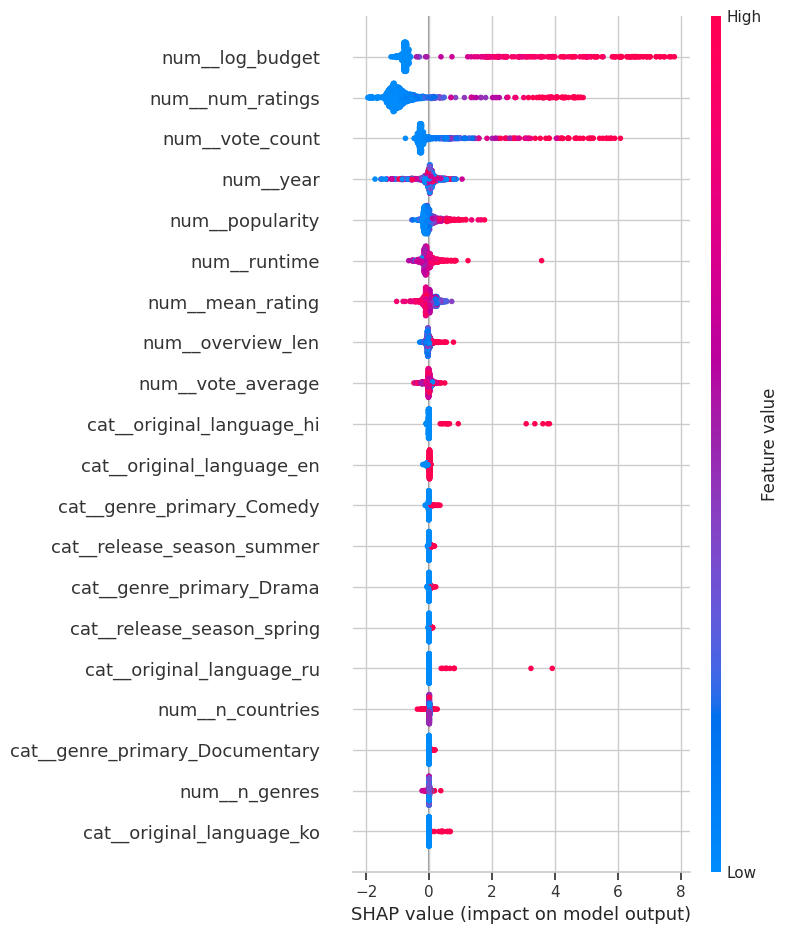

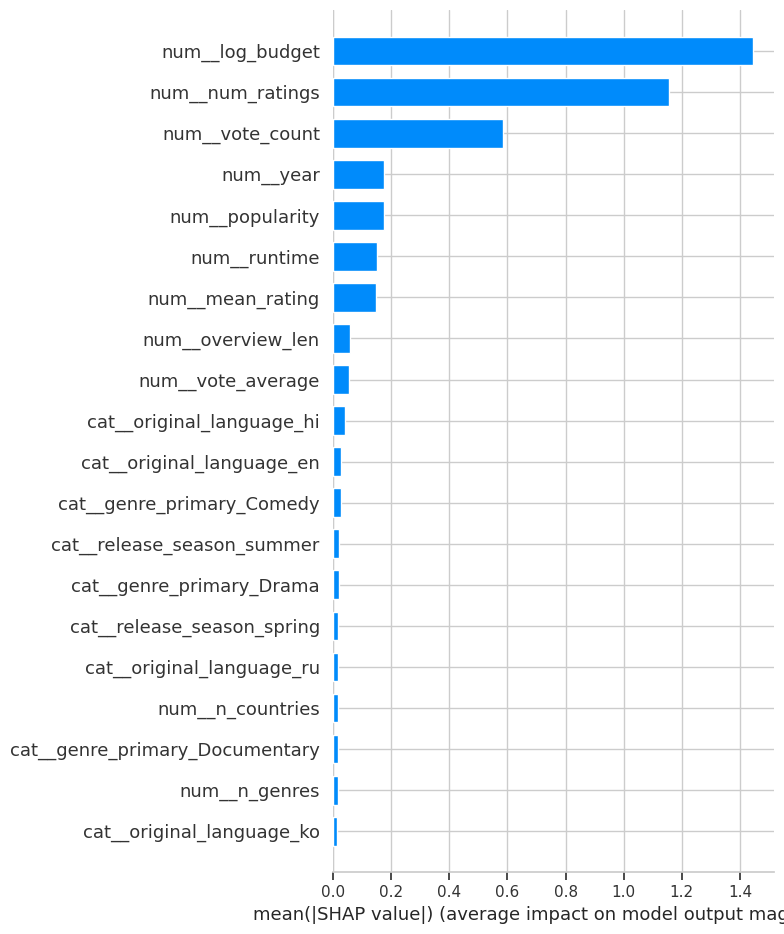

In [50]:
model = rf.named_steps['model']

# background
rng = np.random.RandomState(42)
idx_bg = rng.choice(len(Xt_train), size=min(500, len(Xt_train)), replace=False)
X_bg   = Xt_train[idx_bg]

# TreeExplainer + interventional + sem checagem de aditividade (evita erro)
explainer = shap.TreeExplainer(
    model,
    data=X_bg,
    feature_perturbation='interventional',
    model_output='raw'
)

idx_te = np.random.RandomState(123).choice(len(Xt_test), size=min(800, len(Xt_test)), replace=False)
X_te_sample = Xt_test[idx_te]

shap_values = explainer.shap_values(X_te_sample, check_additivity=False)

# Summary
plt.figure()
shap.summary_plot(shap_values, X_te_sample, feature_names=feature_names, show=False)
plt.show()

# Summary bar
plt.figure()
shap.summary_plot(shap_values, X_te_sample, feature_names=feature_names, plot_type='bar', show=False)
plt.show()

<Figure size 640x480 with 0 Axes>

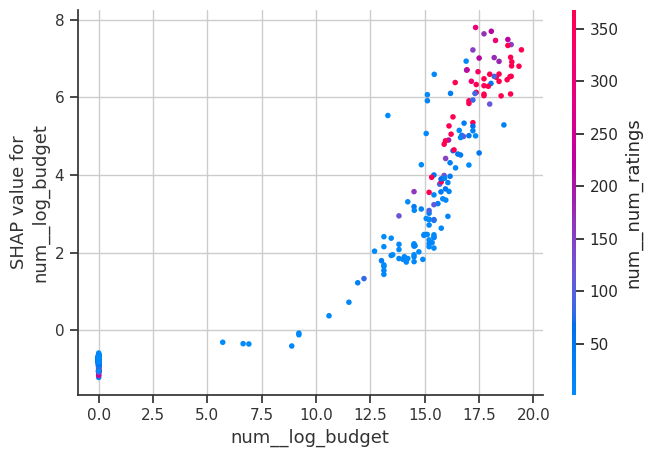

<Figure size 640x480 with 0 Axes>

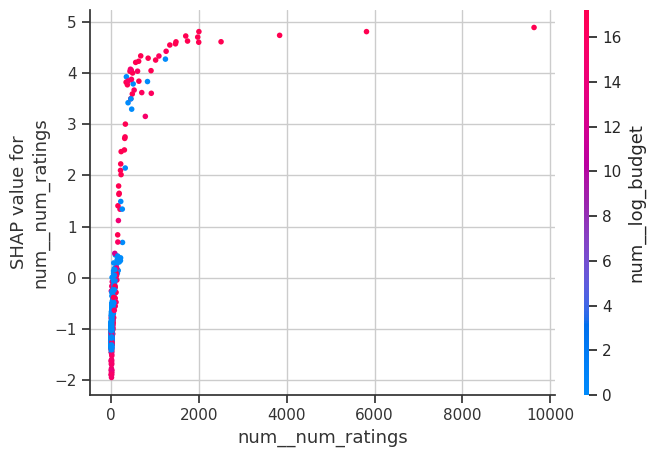

<Figure size 640x480 with 0 Axes>

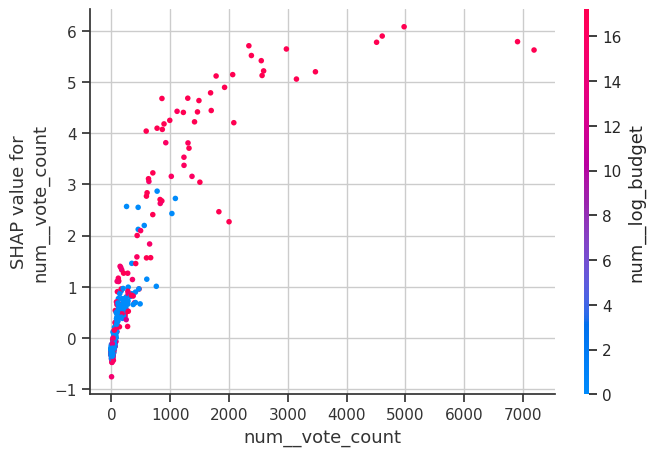

<Figure size 640x480 with 0 Axes>

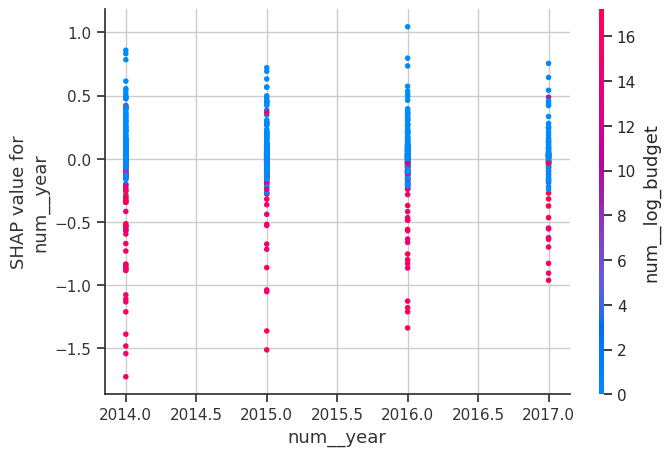

<Figure size 640x480 with 0 Axes>

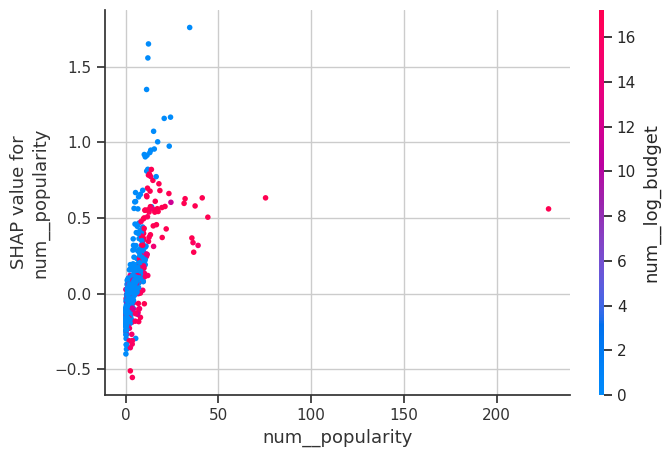

In [51]:
# Plots de dependência
mean_abs = np.abs(shap_values).mean(axis=0)
order = np.argsort(mean_abs)[::-1]
top_idx = order[:5]

for i in top_idx:
    try:
        plt.figure()
        shap.dependence_plot(i, shap_values, X_te_sample, feature_names=feature_names, show=False)
        plt.show()
    except Exception:
        pass

In [52]:
Xt_tr = Xt_train
Xt_te = Xt_test

expl = LimeTabularExplainer(
    training_data = Xt_tr,
    feature_names = feature_names,
    discretize_continuous = True,
    mode = 'regression'
)

# função de predição em USD (modelo está em log-space)
def predict_usd(X_matrix):
    y_log = model.predict(X_matrix)
    # LIME espera 2D. expm1 para voltar ao espaço de receita
    return np.expm1(y_log).reshape(-1, 1)

# explica 3 amostras
idx_samples = np.random.RandomState(1234).choice(len(Xt_te), size=min(3, len(Xt_te)), replace=False)
for i in idx_samples:
    exp = expl.explain_instance(Xt_te[i], predict_usd, num_features=10)
    print(f"\n== LIME para amostra {i} ==")
    for feat, weight in exp.as_list():
        print(f"{feat}: {weight:.3f}")


== LIME para amostra 2127 ==
cat__star1_Jean-Claude Van Damme <= 0.00: -12507419.305
cat__star2_Lou Costello <= 0.00: -12271261.023
cat__director_Clarence Brown <= 0.00: -9608441.127
cat__star4_Alfred Molina <= 0.00: -9300743.455
cat__genre_primary_Mystery <= 0.00: -4183622.959
cat__original_language_sv <= 0.00: -4072529.729
cat__director_Sidney Lumet <= 0.00: -2771750.037
cat__original_language_fi <= 0.00: -2282344.928
cat__original_language_ab <= 0.00: 2128960.303
cat__star1_Paul Newman <= 0.00: 1385492.892

== LIME para amostra 4659 ==
cat__star3_Forest Whitaker <= 0.00: -6694154.195
cat__original_language_cn <= 0.00: -2731070.151
cat__star3_Paresh Rawal <= 0.00: 2311187.531
cat__star1_Marcello Mastroianni <= 0.00: -2280991.654
cat__star3_William R. Moses <= 0.00: -2271698.134
cat__star3_Michael Madsen <= 0.00: -1872188.988
cat__star2_Susan Sarandon <= 0.00: 1416104.059
cat__star3_Donald Pleasence <= 0.00: 95273.586
cat__star4_Mary Steenburgen <= 0.00: 74231.963
cat__original_langu

### K3 — 5.2.2 — Testes Estatísticos e Inferência (ANOVA + OLS Robusto)

Os testes estatísticos reforçaram os achados dos modelos. A ANOVA mostrou diferenças significativas de receita entre gêneros, com destaque positivo para Aventura e negativo para Comédia, Documentário e Horror. O teste t confirmou que filmes em inglês têm, em média, receitas muito superiores (≈ 660% a mais). Análises por diretores e elenco evidenciaram o papel de nomes específicos no sucesso de bilheteria. O modelo linear robusto (HC3) quantificou os efeitos: cada +1 em log_budget está associado a ≈ 72% mais receita, enquanto popularidade e duração também apresentaram impactos positivos menores. Esses resultados validam estatisticamente que tanto características estruturais (orçamento, idioma) quanto criativas (gênero, nomes do elenco) influenciam de forma sistemática a performance financeira dos filmes.

In [53]:
# Cópia de segurança
df_stats = df_h10.copy()

# Parser robusto para genres_list
def to_list_safe(x):
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    if x is None or x is np.nan:
        return []
    s = str(x).strip()
    if not s:
        return []
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else []
    except Exception:
        s2 = re.sub(r'[\[\]\'"]', '', s)
        toks = [t.strip() for t in s2.split(',') if t.strip()]
        return toks

if 'genres_list' in df_stats.columns:
    df_stats['genres_list'] = df_stats['genres_list'].apply(to_list_safe)
else:
    df_stats['genres_list'] = [[]] * len(df_stats)

# Primeiro gênero
def first_genre_from_list(L):
    if isinstance(L, (list, tuple, np.ndarray)) and len(L) > 0:
        return str(L[0])
    return np.nan

if 'genre_primary' not in df_stats.columns:
    df_stats['genre_primary'] = df_stats['genres_list'].apply(first_genre_from_list)

# Alvo em log (robusto a caudas)
df_stats['revenue'] = pd.to_numeric(df_stats['revenue'], errors='coerce')
df_stats['log_rev'] = np.log1p(df_stats['revenue'])

# Binário inglês
if 'is_english' not in df_stats.columns:
    df_stats['original_language'] = df_stats['original_language'].astype(str)
    df_stats['is_english'] = (df_stats['original_language'] == 'en').astype(int)

# Filtros básicos
df_stats = df_stats.replace([np.inf, -np.inf], np.nan).dropna(subset=['log_rev'])

print(df_stats[['genres_list','genre_primary','revenue','log_rev','original_language','is_english']].head(3))
print("Linhas após limpeza:", len(df_stats))


                                         genres_list genre_primary  \
0  [Action, Thriller, Science Fiction, Mystery, A...        Action   
1                   [Drama, Action, Crime, Thriller]         Drama   
2      [Action, Adventure, Fantasy, Science Fiction]        Action   

        revenue  log_rev original_language  is_english  
0  825532764.00    20.53                en           1  
1 1004558444.00    20.73                en           1  
2 2787965087.00    21.75                en           1  
Linhas após limpeza: 45411


In [54]:
# ANOVA
# Mantém gêneros com amostra mínima (p.ex. 30)
vc = df_stats['genre_primary'].value_counts()
keep_genres = vc[vc >= 30].index
df_anova = df_stats[df_stats['genre_primary'].isin(keep_genres)].copy()

# Modelo com intercepto + gênero categórico
m_anova = smf.ols('log_rev ~ C(genre_primary)', data=df_anova).fit()
anova_tbl = anova_lm(m_anova, typ=2)
display(anova_tbl)
print("Categorias significativas vs. baseline (p<0.05):")
print(m_anova.summary().tables[1])

,sum_sq,df,F,PR(>F)
C(genre_primary),47954.66,19.00,68.53,0.00
Residual,1581804.55,42948.00,NaN,NaN


Categorias significativas vs. baseline (p<0.05):
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.4623      0.091     49.236      0.000       4.285       4.640
C(genre_primary)[T.Adventure]           1.0504      0.181      5.815      0.000       0.696       1.405
C(genre_primary)[T.Animation]          -1.5474      0.202     -7.644      0.000      -1.944      -1.151
C(genre_primary)[T.Comedy]             -1.6120      0.111    -14.480      0.000      -1.830      -1.394
C(genre_primary)[T.Crime]              -1.3538      0.173     -7.805      0.000      -1.694      -1.014
C(genre_primary)[T.Documentary]        -3.7781      0.138    -27.398      0.000      -4.048      -3.508
C(genre_primary)[T.Drama]              -1.9898      0.106    -18.721      0.000      -2.198      -1.781
C(genre_primary

In [55]:
# teste t
g_en  = df_stats.loc[df_stats['is_english']==1, 'log_rev']
g_non = df_stats.loc[df_stats['is_english']==0, 'log_rev']

t_stat, p_val = ttest_ind(g_en, g_non, equal_var=False, nan_policy='omit')
print(f"t-test (EN vs não-EN): t={t_stat:.3f}, p={p_val:.3g}")
print(f"Médias (log): EN={g_en.mean():.3f}, Não-EN={g_non.mean():.3f}")
print(f"Δ% ~ {100*np.expm1(g_en.mean()-g_non.mean()):.1f}% (aprox.)")

t-test (EN vs não-EN): t=40.088, p=0
Médias (log): EN=3.192, Não-EN=1.155
Δ% ~ 666.4% (aprox.)


In [56]:
# Efeito de diretor e elenco (estatística descritiva + filtro por contagem)
min_count = 10 

# Diretores
dir_mean = (df_stats.dropna(subset=['director'])
            .groupby('director')['log_rev']
            .agg(['mean','count'])
            .sort_values('mean', ascending=False))
display(dir_mean[dir_mean['count']>=min_count].head(15))

# Elenco: empilha star1..star4
star_cols = ['star1','star2','star3','star4']
cast_s = pd.concat([df_stats[c].dropna().astype(str) for c in star_cols], axis=0)
cast_logrev = pd.concat([df_stats.loc[df_stats[c].notna(), 'log_rev'] for c in star_cols], axis=0)

cast_tbl = (pd.DataFrame({'person': cast_s.values, 'log_rev': cast_logrev.values})
            .groupby('person')['log_rev']
            .agg(['mean','count'])
            .sort_values('mean', ascending=False))
display(cast_tbl[cast_tbl['count']>=min_count].head(20))

,mean,count
director,,
Michael Bay,19.69,13
David Fincher,19.06,10
Gore Verbinski,18.96,10
Barry Sonnenfeld,18.48,11
Wolfgang Petersen,18.39,10
Bobby Farrelly,18.14,11
Ridley Scott,17.54,24
Steven Spielberg,17.41,33
Tony Scott,17.10,17


,mean,count
person,,
Emma Watson,18.03,17
Dwayne Johnson,17.86,26
Emma Stone,17.41,18
Tom Cruise,17.06,40
Will Smith,17.04,25
Matt Damon,16.91,41
Steve Carell,16.87,25
Channing Tatum,16.78,20
Christoph Waltz,16.54,10


In [57]:
# Modelo Linear "explicativo" com dummies + erros robustos
# 1) Mesmo setup de dados
df_lin = df_stats.copy()

cols_lin = [
    'log_rev','log_budget','popularity','runtime',
    'is_english','has_director','has_stars',
    'genre_primary','original_language'
]
cols_lin = [c for c in cols_lin if c in df_lin.columns]
df_lin = df_lin.replace([np.inf,-np.inf], np.nan).dropna(subset=cols_lin).copy()

# reduz cardinalidade
for col, k in [('genre_primary', 20), ('original_language', 10)]:
    if col in df_lin.columns:
        top = df_lin[col].value_counts().head(k).index
        df_lin[col] = df_lin[col].where(df_lin[col].isin(top), 'Other')

# Fórmula
fml = 'log_rev ~ log_budget + popularity + runtime + C(is_english) + C(has_director) + C(has_stars)'
if 'genre_primary' in df_lin.columns:
    fml += ' + C(genre_primary)'
if 'original_language' in df_lin.columns:
    fml += ' + C(original_language)'

# Ajusta OLS “padrão”
res = smf.ols(fml, data=df_lin).fit()

# Aplica covariância robusta (HC3) *após* o fit
rob = res.get_robustcov_results(cov_type='HC3')

print(rob.summary())

                            OLS Regression Results                            
Dep. Variable:                log_rev   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     509.1
Date:                Fri, 12 Sep 2025   Prob (F-statistic):               0.00
Time:                        13:15:33   Log-Likelihood:            -1.2474e+05
No. Observations:               42958   AIC:                         2.495e+05
Df Residuals:                   42920   BIC:                         2.499e+05
Df Model:                          37                                         
Covariance Type:                  HC3                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [58]:
print("Δ% receita p/ +1 em log_budget:", round((np.exp(0.5414)-1)*100, 1), "%")
print("Δ% receita p/ +1 em popularity:", round((np.exp(0.2073)-1)*100, 1), "%")
print("Δ% receita p/ +1 min runtime:",   round((np.exp(0.0075)-1)*100, 2), "%")

Δ% receita p/ +1 em log_budget: 71.8 %
Δ% receita p/ +1 em popularity: 23.0 %
Δ% receita p/ +1 min runtime: 0.75 %


In [59]:
# Kruskal-Wallis (substitui ANOVA)
df_kw = df_anova.copy()
groups = [g['log_rev'].values for _, g in df_kw.groupby('genre_primary')]
stat, p = kruskal(*groups)
print(f"Kruskal–Wallis (gêneros): H={stat:.2f}, p={p:.3g}")

Kruskal–Wallis (gêneros): H=1173.87, p=3.64e-237


## K3 — 5.3 — H11. Previsão de Nota IMDb

### K3 — 5.3.1 — Formulação do Problema

* **Explicação da Previsão de Nota IMDb:**
    * Qual problema estamos resolvendo? 
      * A Tarefa de Machine Learning a ser resolvida é de regressão (previsão), onde a variável alvo é a ``vote_average´´ (nota IMDb média), que é contínua (escala 0-10). Portanto, o setup é de **regressão supervisionada**.
    * Quais variáveis usar e por quê?
      * Numéricas diretas (já normalizadas ou log-transformadas): log_budget, log_revenue, roi, runtime, popularity, vote_count, mean_rating, num_ratings, overview_len.
      * Categóricas de baixa cardinalidade (redução prévia): original_language (colapsado em top-10 + “Other”). release_season (primavera, verão, outono, inverno). n_genres e n_countries (tratados como discretos, mas numéricos).
      * Texto: overview (transformado via TF-IDF [limitando vocabulário, ex.: 500–1000 termos]. Isso captura sinais semânticos da sinopse).
      * Elenco e direção: director, star1..4 (apenas se reduzir cardinalidade [ex.: top-100 por frequência, resto em “Other”]).
    * Modelos possíveis: Linear (Regressão Linear/ElasticNet): simples, interpretável, mas limitado se houver não-linearidades. Árvores de decisão (Random Forest, Gradient Boosting): capturam não-linearidade e interações, lidam bem com mix numérico + categórico. Modelos baseados em texto (TF-IDF + Regressão): permitem capturar sinais semânticos adicionais da sinopse.
    * Melhor equilíbrio: Random Forest Regressor (ou Gradient Boosting), pois estamos trabalhando com dados heterogêneos (números + categorias + texto) e a relação entre variáveis não é linear.
    * Métricas de avaliação: RMSE (Root Mean Squared Error): mostra o erro médio em “pontos de nota IMDb”. R²: quanto da variância do target o modelo explica (0–1).

In [61]:
# Carregando a base de dados
df_h11 = df_master.copy()

### K3 — 5.3.2 — Seleção de Features e Preparação

In [62]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

In [65]:
df = df_h11.copy()

title_holdout = 'The Shawshank Redemption'
if 'original_title_norm' in df.columns:
    leak_mask = (
        df['original_title_norm'].astype(str).str.strip().str.lower().eq(title_holdout.lower())
        | df['original_title_norm'].astype(str).str.contains('shawshank', case=False, na=False)
    )
else:
    leak_mask = pd.Series(False, index=df.index)
df = df.loc[~leak_mask].copy()

y = pd.to_numeric(df['vote_average'], errors='coerce')

def _first_genre(x):
    if x is None:
        return np.nan
    try:
        if isinstance(x, float) and np.isnan(x):
            return np.nan
    except TypeError:
        pass
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(x, (list, tuple)):
        return x[0] if len(x) > 0 else np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan
    return s.split("|")[0] if "|" in s else s

df['genre_primary'] = df['genres_list'].apply(_first_genre)


num_cols_all = [
    'log_budget','log_revenue','roi','runtime','popularity',
    'vote_count','mean_rating','num_ratings','n_countries','n_genres',
    'overview_len','is_english','year'
]
cat_cols_all = [
    'original_language','release_season','genre_primary',
    'director','star1','star2','star3','star4'
]
txt_col = 'overview'

num_cols = [c for c in num_cols_all if c in df.columns]
cat_cols = [c for c in cat_cols_all if c in df.columns]
use_cols = num_cols + cat_cols + ([txt_col] if txt_col in df.columns else [])

X = df[use_cols].copy()

mask = y.notna()
X = X.loc[mask]
y = y.loc[mask]

for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce').replace([np.inf,-np.inf], np.nan)
for c in cat_cols:
    X[c] = X[c].astype('object')
if txt_col in X.columns:
    X[txt_col] = X[txt_col].astype(str)

if 'year' in X.columns:
    q_train = X['year'].quantile(0.70)
    q_valid = X['year'].quantile(0.85)
    tr_idx  = X['year'] <= q_train
    va_idx  = (X['year'] > q_train) & (X['year'] <= q_valid)
    te_idx  = X['year'] > q_valid

    X_train, y_train = X[tr_idx].copy(), y[tr_idx].copy()
    X_valid, y_valid = X[va_idx].copy(), y[va_idx].copy()
    X_test,  y_test  = X[te_idx].copy(), y[te_idx].copy()
else:
    from sklearn.model_selection import train_test_split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, random_state=42)
    X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.1765, random_state=42)
    X_train, y_train = X_tr.copy(), y_tr.copy()
    X_valid, y_valid = X_va.copy(), y_va.copy()
    X_test,  y_test  = X_te.copy(), y_te.copy()

print(len(X_train), len(X_valid), len(X_test))

32538 6770 6013


In [66]:
# Redução de cardinalidade - númericas, categóricas e textuais
for c, k in [('original_language', 10), ('genre_primary', 20), ('director', 100), ('star1', 100), ('star2', 100), ('star3', 100), ('star4', 100)]:
    if c in X_train.columns:
        top = X_train[c].astype(str).fillna('UNK').value_counts().head(k).index
        X_train[c] = X_train[c].astype(str).fillna('UNK').where(X_train[c].isin(top), 'Other')
        if c in X_valid.columns: X_valid[c] = X_valid[c].astype(str).fillna('UNK').where(X_valid[c].isin(top), 'Other')
        if c in X_test.columns:  X_test[c]  = X_test[c].astype(str).fillna('UNK').where(X_test[c].isin(top),  'Other')

### K3 — 5.3.3 — Pré-processamento

In [67]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pipes = []
if len(num_cols) > 0:
    pipes.append(('num', num_pipe, num_cols))
if len(cat_cols) > 0:
    pipes.append(('cat', cat_pipe, cat_cols))
if txt_col in X_train.columns:
    pipes.append(('txt', TfidfVectorizer(max_features=1000, ngram_range=(1,2)), txt_col))

prep = ColumnTransformer(pipes, remainder='drop', verbose_feature_names_out=False)

### K3 — 5.3.4 — Modelos Candidatos

In [68]:
def train_eval(name, est, prep, Xtr, ytr, Xv, yv, Xt, yt):
    pipe = Pipeline([("prep", prep), ("model", est)])
    pipe.fit(Xtr, ytr)
    yv_pred = pipe.predict(Xv)
    yt_pred = pipe.predict(Xt)
    return {
        "model": name,
        "rmse_val": np.sqrt(mean_squared_error(yv, yv_pred)),
        "mae_val":  mean_absolute_error(yv, yv_pred),
        "r2_val":   r2_score(yv, yv_pred),
        "rmse_test": np.sqrt(mean_squared_error(yt, yt_pred)),
        "mae_test":  mean_absolute_error(yt, yt_pred),
        "r2_test":   r2_score(yt, yt_pred),
        "pipe": pipe,
    }


In [69]:
# Definindo os Modelos
models = {
    "lin": LinearRegression(),
    "ridge": Ridge(alpha=1.0, random_state=42),
    "enet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=1000),
    "rf": RandomForestRegressor(
        max_depth=10, min_samples_leaf=2, min_samples_split=5,
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    "hgb": HistGradientBoostingRegressor(
        learning_rate=0.08, max_depth=8, min_samples_leaf=20,
        l2_regularization=0.1, random_state=42
    ),
}

### K3 — 5.3.5 — Treinamento e Avaliação dos Modelos

In [70]:
results = []
for name, est in models.items():
    print(f"Treinando {name}...")
    res = train_eval(name, est, prep, X_train, y_train, X_valid, y_valid, X_test, y_test)
    results.append(res)

metrics = pd.DataFrame([{k: v for k, v in r.items() if k != "pipe"} for r in results])
metrics = metrics.sort_values("rmse_val").reset_index(drop=True)
metrics

Treinando lin...
Treinando ridge...
Treinando enet...
Treinando rf...
Treinando hgb...


,model,rmse_val,mae_val,r2_val,rmse_test,mae_test,r2_test
0,hgb,0.95,0.65,0.68,1.13,0.76,0.66
1,rf,0.97,0.67,0.66,1.14,0.77,0.65
2,enet,1.56,1.07,0.14,2.06,1.33,-0.14
3,ridge,1.56,1.07,0.14,2.03,1.32,-0.10
4,lin,1.56,1.07,0.13,2.03,1.32,-0.10


### K3 — 5.3.6 — Escolha e Persistência do Modelo Final

In [ ]:
best = min(results, key=lambda x: x["rmse_val"])
print("Melhor modelo:", best["model"], "| RMSE Val:", best["rmse_val"])

model_path = PATHS.MODELS / 'h11_imdb_rating_model.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(best, f)

Melhor modelo: hgb | RMSE Val: 0.9450928779682803


### K3 — 5.3.7 — Predição do Filme

In [98]:
def build_row_from_lighthouse(movie_dict: dict, required_cols: list[str]) -> pd.DataFrame:
    m = pd.DataFrame([movie_dict]).copy()

    m['runtime'] = pd.to_numeric(m.get('Runtime','').astype(str).str.extract(r'(\d+)')[0], errors='coerce')
    m['overview'] = m.get('Overview','').astype(str)
    m['overview_len'] = m['overview'].str.len()
    m['vote_count'] = pd.to_numeric(m.get('No_of_Votes', np.nan), errors='coerce')

    gross_clean = m.get('Gross', np.nan)
    if isinstance(gross_clean, pd.Series):
        gross_clean = gross_clean.astype(str).str.replace('[^0-9]','', regex=True)
    m['revenue'] = pd.to_numeric(gross_clean, errors='coerce')
    m['log_revenue'] = np.log1p(m['revenue'])

    m['log_budget'] = np.nan
    m['roi'] = np.nan
    m['original_language'] = 'en'
    m['is_english'] = 1
    m['year'] = pd.to_numeric(m.get('Released_Year', np.nan), errors='coerce')

    genre_str = m.get('Genre','').astype(str)
    m['genre_primary'] = genre_str.str.split(',').str[0].str.strip()
    m['n_genres'] = genre_str.apply(lambda s: len([g for g in s.split(',') if g.strip()]))

    m['n_countries'] = np.nan
    m['popularity']  = np.nan
    m['mean_rating'] = np.nan
    m['num_ratings'] = m['vote_count']
    m['release_season'] = 'fall'

    m['director'] = m.get('Director','').astype(str)
    m['star1'] = m.get('Star1','').astype(str)
    m['star2'] = m.get('Star2','').astype(str)
    m['star3'] = m.get('Star3','').astype(str)
    m['star4'] = m.get('Star4','').astype(str)

    row = pd.DataFrame([{c: np.nan for c in required_cols}])
    for c in required_cols:
        if c in m.columns:
            row[c] = m[c].iloc[0]
    return row

In [99]:
movie = {
 'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'
}

In [100]:
# --- Carrega o objeto salvo  ---
model_path = PATHS.MODELS / 'h11_imdb_rating_model.pkl'
with open(model_path, 'rb') as f:
    obj = pickle.load(f)

# Extrai o pipeline e o nome do modelo
if isinstance(obj, dict):
    pipe = obj['pipe']          
    model_name = obj.get('model', 'unknown')
else:
    pipe = obj
    model_name = getattr(pipe, 'model', 'unknown')

# --- Extrai o 'prep' e as colunas esperadas ---
prep = pipe.named_steps['prep']

def _to_list(cols):
    if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
        return list(cols)
    return [cols]

req_cols = []
for name, transf, cols in prep.transformers_:
    if cols is None or cols == 'drop':
        continue
    req_cols.extend([str(c) for c in _to_list(cols)])
req_cols = sorted(pd.unique(req_cols))

cat_cols_expected = []
for name, transf, cols in prep.transformers_:
    if name == 'cat':
        cat_cols_expected.extend([str(c) for c in _to_list(cols)])
cat_cols_expected = list(pd.unique(cat_cols_expected))

# --- Monta a linha nova nas colunas corretas ---
x_new = build_row_from_lighthouse(movie, req_cols)
if isinstance(x_new, pd.Series):
    x_new = x_new.to_frame().T
x_new = x_new.reindex(columns=req_cols)

for c in cat_cols_expected:
    if c in x_new.columns:
        x_new[c] = x_new[c].astype(str).fillna('UNK')

# --- Predição sempre pelo PIPELINE ---
pred = float(pipe.predict(x_new)[0])
print(f"[{model_name}] Nota prevista p/ The Shawshank Redemption: {round(pred, 2)}")


[hgb] Nota prevista p/ The Shawshank Redemption: 6.34


In [101]:
# Comparando com a nota oficial
df_vote_average = df_h11[df_h11['original_title_norm'].str.contains('the shawshank redemption', case=False)]['vote_average']
df_vote_average

19   8.50
Name: vote_average, dtype: float64